# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [393]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport stopping_power_ml
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in Data
Read in data from all velocities

In [317]:
import gzip

data = pkl.load(gzip.open('../training_data.pkl.gz', 'rb'))

## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

Text(0,0.5,'Force')

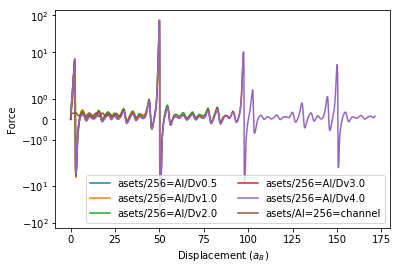

In [318]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Text(0,0.5,'Force')

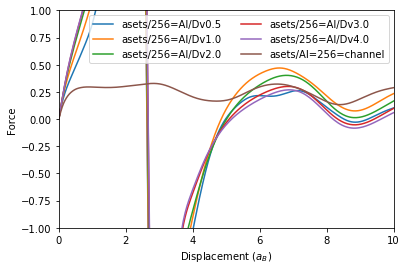

In [319]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)

ax.set_xlim(0, 10)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

In [320]:
set(data['directory'])

{'datasets/256_Al/Dv0.5',
 'datasets/256_Al/Dv1.0',
 'datasets/256_Al/Dv2.0',
 'datasets/256_Al/Dv3.0',
 'datasets/256_Al/Dv4.0',
 'datasets/Al_256_channel'}

Andre uses 6 $a_B$

In [321]:
data.query('displacement >= 6', inplace=True)
data.query("directory != 'datasets/Al_256_channel'", inplace=True)

## Generate Features
Use the same features at the Al model

In [331]:
featurizers = pkl.load(open('../featurizers.pkl', 'rb'))

In [323]:
'''
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)
'''

"\n%%time\nfor f in featurizers:\n    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)\n"

In [356]:
data['velocity_str'] = [str(velocity) for velocity in data['velocity']]
data['v0'] = [ v[0] for v in data['velocity'] ]
data['v1'] = [ v[1] for v in data['velocity'] ]
data['v2'] = [ v[2] for v in data['velocity'] ]

In [334]:
X_cols = sum([f.feature_labels() for f in featurizers.featurizers], [])
X_cols_orig = X_cols.copy()
V_cols = ['v0','v1','v2']
X_cols += V_cols
y_col = 'force'

In [326]:
#data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [327]:
#X_cols += ['velocity_mag',]

In [337]:
print('Features: {}'.format(len(X_cols_orig)))
V_cols


Features: 18


['v0', 'v1', 'v2']

In [252]:
'''
for i in range(-2, 2):
    if i != 0:
        a = 'velocity_mag_exp=%i'%i
        data[a] = np.exp(i * data['velocity_mag'])
        X_cols += [a,]
'''

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [343]:
def fit_on_whole_dataset(model, callbacks=[], epochs=1, split_v=False):

    if split_v:
        try:
            model.fit([data[X_cols_orig], data[V_cols]], data[y_col], epochs=epochs, callbacks=callbacks)
        except Exception as e:
            print(e)
            model.fit([data[X_cols_orig], data[V_cols]], data[y_col])
        
    else:
        try:
            model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks)
        except Exception as e:
            print(e)
            model.fit(data[X_cols], data[y_col])
            
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_orig], data[V_cols]])
    else:
        data['force_fit'] = model.predict(data[X_cols])

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        if split_v:
            ax[0].plot(group['displacement'], model.predict([group[X_cols_orig], group[V_cols]]), color=my_line.get_color(), lw=5, alpha=0.3)
        else:
            ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax

In [275]:
def build_dense_model(layers, input_shape, activation, optimizer='adam', loss='mean_absolute_error', summary=False):
    model = Sequential()
    model.add(Dense(layers[0], input_shape=input_shape, activation=activation))
    for layer in layers[1:]:
        model.add(Dense(layer, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    if summary:
        model.summary()
    return model

In [314]:
def build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, activation, merge_type=Multiply, optimizer='adam', loss='mean_absolute_error', summary=False):
    main_input = Input(shape=input_shape)
    l = Dense(layers[0], activation=activation)(main_input)
    for layer in layers[1:]:
        l = (Dense(layer, activation=activation))(l)
        
    v_input = Input(shape=v_input_shape)
    r = Dense(v_layers[0], activation=activation)(v_input)
    for v_layer in v_layers[1:]:
        r = (Dense(v_layer, activation=activation))(r)
        
    m = merge_type()([l, r])
    for m_layer in m_layers:
        m = (Dense(m_layer, activation=activation))(m)
        
    output = Dense(1, activation='linear')(m)
    
    model = Model(inputs=[main_input, v_input], 
                         outputs=[output])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    if summary:
        model.summary()
    return model

Epoch 1/150
46349/46349 [==============================] - 6s 139us/step - loss: 0.3297 - mean_absolute_error: 0.3297
Epoch 2/150
46349/46349 [==============================] - 5s 107us/step - loss: 0.2577 - mean_absolute_error: 0.2577
Epoch 3/150
46349/46349 [==============================] - 6s 126us/step - loss: 0.2445 - mean_absolute_error: 0.2445
Epoch 4/150
46349/46349 [==============================] - 6s 129us/step - loss: 0.2335 - mean_absolute_error: 0.2335
Epoch 5/150
46349/46349 [==============================] - 5s 105us/step - loss: 0.2284 - mean_absolute_error: 0.2284
Epoch 6/150
46349/46349 [==============================] - 5s 112us/step - loss: 0.2170 - mean_absolute_error: 0.2170
Epoch 7/150
46349/46349 [==============================] - 5s 113us/step - loss: 0.2102 - mean_absolute_error: 0.2102
Epoch 8/150
46349/46349 [==============================] - 5s 109us/step - loss: 0.2049 - mean_absolute_error: 0.2049
Epoch 9/150
46349/46349 [==============================]

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe708c9ac88>,
       dtype=object))

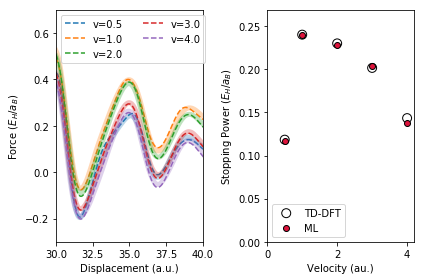

In [348]:
#model1 = build_velocity_merge_model((18, 16, 8), (3, 6, 8), (8, 4), (18,), (3,), 'relu', summary=True)

input_shape = (18,)
v_input_shape = (3,)
layers = (input_shape[0],16,12,8,4,3)
v_layers = (v_input_shape[0],3,3)
m_layers = (layers[-1],3)
activation = 'elu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 150

callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto')]

fit_on_whole_dataset( build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, activation), 
                     callbacks=callbacks, epochs=epochs, split_v=True )

Epoch 1/250
46349/46349 [==============================] - 5s 108us/step - loss: 0.1731 - mean_absolute_error: 0.1731
Epoch 2/250
46349/46349 [==============================] - 4s 80us/step - loss: 0.0481 - mean_absolute_error: 0.0481
Epoch 3/250
46349/46349 [==============================] - 4s 76us/step - loss: 0.0408 - mean_absolute_error: 0.0408
Epoch 4/250
46349/46349 [==============================] - 3s 75us/step - loss: 0.0353 - mean_absolute_error: 0.0353
Epoch 5/250
46349/46349 [==============================] - 4s 79us/step - loss: 0.0335 - mean_absolute_error: 0.0335
Epoch 6/250
46349/46349 [==============================] - 4s 78us/step - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 7/250
46349/46349 [==============================] - 4s 76us/step - loss: 0.0315 - mean_absolute_error: 0.0315
Epoch 8/250
46349/46349 [==============================] - 4s 81us/step - loss: 0.0307 - mean_absolute_error: 0.0307
Epoch 9/250
46349/46349 [==============================] - 4s 8

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe709d94710>,
       dtype=object))

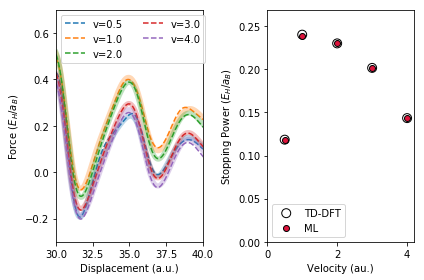

In [347]:
input_shape = (21,)
layers = (input_shape[0],16,8,4)
activation = 'elu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 250

callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto')]

fit_on_whole_dataset( build_dense_model(layers, input_shape, activation), callbacks=callbacks, epochs=epochs )

You'll note the model predictions (thick, translucent lines) <del>do not really differ based on velocity, and nor do the predicted stopping powers</del>

Epoch 1/100
46349/46349 [==============================] - 5s 99us/step - loss: 0.2621 - mean_absolute_error: 0.2621
Epoch 2/100
46349/46349 [==============================] - 4s 76us/step - loss: 0.0477 - mean_absolute_error: 0.0477
Epoch 3/100
46349/46349 [==============================] - 3s 64us/step - loss: 0.0383 - mean_absolute_error: 0.0383
Epoch 4/100
46349/46349 [==============================] - 3s 65us/step - loss: 0.0351 - mean_absolute_error: 0.0351
Epoch 5/100
46349/46349 [==============================] - 3s 66us/step - loss: 0.0329 - mean_absolute_error: 0.0329
Epoch 6/100
46349/46349 [==============================] - 3s 69us/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 7/100
46349/46349 [==============================] - 3s 64us/step - loss: 0.0285 - mean_absolute_error: 0.0285
Epoch 8/100
46349/46349 [==============================] - 3s 67us/step - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 9/100
46349/46349 [==============================] - 3s 66

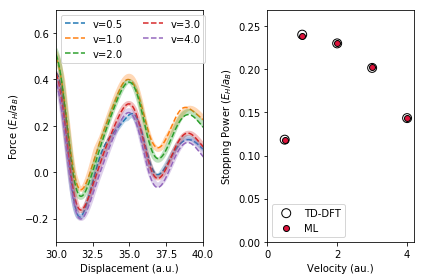

In [296]:
fig, ax = fit_on_whole_dataset( build_dense_model(layers, input_shape, activation), callbacks=callbacks, epochs=epochs )

fig.savefig('figures/Al_all_velocities.png', dpi=320)
fig.savefig('figures/Al_all_velocities.pdf')

The predictions do change with the velocities √

## Leave-one-velocity-out Cross-Validation
Can we interpolate between different velocities?

Andre uses 6 $a_B$

In [390]:
velocity_strs = set(data['velocity_str'])

datasets/256_Al/Dv1.0


In [359]:
train_sets = []
test_sets = []

for vel in velocity_strs:
    train_sets.append(data.query("velocity_str != '{}'".format(vel)))
    test_sets.append(data.query("velocity_str == '{}'".format(vel)))

In [392]:
def show_prediction_scatter(test_set):
    dirname = test_set['directory'].iloc[0]
    plt.figure()
    plt.title('{} Force Preds'.format(dirname))
    plt.xlabel('Actual Force')
    plt.ylabel('Prediction')
    plt.scatter(test_set['force'], test_set['force_fit'])
    plt.show()

In [395]:
def fit_and_cross_test(model, train_set, test_set, callbacks=[], epochs=1, split_v=False, verbose=0):

    if split_v:
        try:
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], verbose=verbose)
        
    else:
        try:
            model.fit(train_set[X_cols], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit(train_set[X_cols], train_set[y_col], verbose=verbose)
            
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_orig], data[V_cols]])
        test_set['force_fit'] = model.predict([test_set[X_cols_orig], test_set[V_cols]])
    else:
        data['force_fit'] = model.predict(data[X_cols])
        test_set['force_fit'] = model.predict(test_set[X_cols])
        

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        if split_v:
            ax[0].plot(group['displacement'], model.predict([group[X_cols_orig], group[V_cols]]), color=my_line.get_color(), lw=5, alpha=0.3)
        else:
            ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00129: ReduceLROnPl

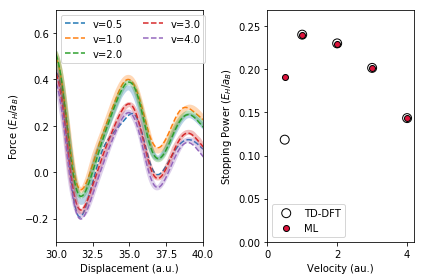

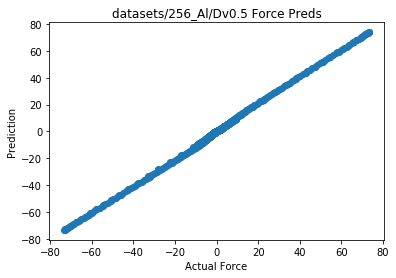

In [403]:
input_shape = (21,)
layers = (input_shape[0],18,16,12,8,4)
activation = 'selu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 250
i = 3

callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto'),
            EarlyStopping(monitor='mean_absolute_error', patience=15, verbose=0, mode='auto')]

fit_and_cross_test( build_dense_model(layers, input_shape, activation), train_sets[i], test_sets[i],
                   callbacks=callbacks, epochs=epochs, verbose=0)
show_prediction_scatter(test_sets[i])

In [ ]:
input_shape = (21,)
layers = (input_shape[0],18,16,12,8,4)
activation = 'selu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 250
#i = 0



for i in range(2, len(train_sets)):
    callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto'),
            EarlyStopping(monitor='mean_absolute_error', patience=15, verbose=1, mode='auto')]
    
    fit_and_cross_test( build_dense_model(layers, input_shape, activation), train_sets[i], test_sets[i],
                   callbacks=callbacks, epochs=epochs, verbose=1)
    show_prediction_scatter(test_sets[i])

Epoch 1/250
38560/38560 [==============================] - 6s 160us/step - loss: 0.2063 - mean_absolute_error: 0.2063
Epoch 2/250
38560/38560 [==============================] - 4s 102us/step - loss: 0.0716 - mean_absolute_error: 0.0716
Epoch 3/250
38560/38560 [==============================] - 5s 119us/step - loss: 0.0591 - mean_absolute_error: 0.0591
Epoch 4/250
38560/38560 [==============================] - 4s 111us/step - loss: 0.0523 - mean_absolute_error: 0.0523
Epoch 5/250
38560/38560 [==============================] - 4s 107us/step - loss: 0.0483 - mean_absolute_error: 0.0483
Epoch 6/250
38560/38560 [==============================] - 4s 106us/step - loss: 0.0467 - mean_absolute_error: 0.0467
Epoch 7/250
38560/38560 [==============================] - 4s 103us/step - loss: 0.0445 - mean_absolute_error: 0.0445
Epoch 8/250
38560/38560 [==============================] - 4s 107us/step - loss: 0.0436 - mean_absolute_error: 0.0436
Epoch 9/250
38560/38560 [==============================]